## Introduction
This file is concerned with the second asssignment in the ST 443 group project. The task is on a high-dimensional binary classification problem using neural spike-count data recorded from the mouse frontal cortex during a decision-making task. Each trial contains spike activity from 2238 neurons across 5 time bins, resulting in 11,190 features, while the dataset includes only 683 trials. Hence we need to have minimal number of features to avoid p>n. We will start with T2.1, which is concerned with data visualization and understanding the distribution of the features, and the target.

## Data Preparation and Imports

### Import

In [1]:
# Load the dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import numpy as np

### Read the csv file

In [2]:
data2 = pd.read_csv("data-2.csv.gz") # Data already in local directory, don't worry about absolute paths
input2 = data2.drop(columns=["label"])
target2 = data2["label"]

## Task 2.1: EDA

Inspect the dataset

In [3]:
#Shape of the dataframe
print(f"\n Number of Rows: {data2.shape[0]} \n Number of Columns: {data2.shape[1]}")
# 11900 features + 1 target


 Number of Rows: 683 
 Number of Columns: 11191


In [4]:
#Datatypes of all the columns in the dataset
data2.dtypes

label              int64
unit_0000_bin_0    int64
unit_0001_bin_0    int64
unit_0002_bin_0    int64
unit_0003_bin_0    int64
                   ...  
unit_2233_bin_4    int64
unit_2234_bin_4    int64
unit_2235_bin_4    int64
unit_2236_bin_4    int64
unit_2237_bin_4    int64
Length: 11191, dtype: object

In [5]:
#Information about the dataset
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Columns: 11191 entries, label to unit_2237_bin_4
dtypes: int64(11191)
memory usage: 58.3 MB


In [6]:
#Look at the first 5 entries
data2.head()

,label,unit_0000_bin_0,unit_0001_bin_0,unit_0002_bin_0,unit_0003_bin_0,unit_0004_bin_0,unit_0005_bin_0,unit_0006_bin_0,unit_0007_bin_0,unit_0008_bin_0,...,unit_2228_bin_4,unit_2229_bin_4,unit_2230_bin_4,unit_2231_bin_4,unit_2232_bin_4,unit_2233_bin_4,unit_2234_bin_4,unit_2235_bin_4,unit_2236_bin_4,unit_2237_bin_4
0,1,1,0,0,2,6,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,4,8,0,3,9,13,6,3,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,5,0,2,7,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,8,0,0,6,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,1,3,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Summary statistics

In [7]:
#Summary statistics of the float columns
data2.select_dtypes(include="number").describe()

,label,unit_0000_bin_0,unit_0001_bin_0,unit_0002_bin_0,unit_0003_bin_0,unit_0004_bin_0,unit_0005_bin_0,unit_0006_bin_0,unit_0007_bin_0,unit_0008_bin_0,...,unit_2228_bin_4,unit_2229_bin_4,unit_2230_bin_4,unit_2231_bin_4,unit_2232_bin_4,unit_2233_bin_4,unit_2234_bin_4,unit_2235_bin_4,unit_2236_bin_4,unit_2237_bin_4
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.0,...,683.0,683.000000,683.000000,683.0,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,0.695461,1.512445,2.991215,0.237189,0.756955,1.286969,1.446559,0.931186,1.070278,0.0,...,0.0,0.127379,0.067350,0.0,0.207906,0.004392,0.029283,0.089312,0.001464,0.035139
std,0.460549,1.368178,1.935904,0.660551,1.239415,2.622303,3.198882,1.541111,1.504941,0.0,...,0.0,0.459373,0.278512,0.0,0.601169,0.066178,0.246424,0.449098,0.038264,0.245656
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,4.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,7.000000,10.000000,5.000000,9.000000,15.000000,19.000000,9.000000,11.000000,0.0,...,0.0,4.000000,2.000000,0.0,5.000000,1.000000,3.000000,4.000000,1.000000,3.000000


Missing values

In [8]:
#Missing values
print("Missing values", data2.isnull().any().any())

Missing values False


Duplicates

In [9]:
#Duplicates check
print("Duplicates", data2[data2.duplicated() == True])

Duplicates Empty DataFrame
Columns: [label, unit_0000_bin_0, unit_0001_bin_0, unit_0002_bin_0, unit_0003_bin_0, unit_0004_bin_0, unit_0005_bin_0, unit_0006_bin_0, unit_0007_bin_0, unit_0008_bin_0, unit_0009_bin_0, unit_0010_bin_0, unit_0011_bin_0, unit_0012_bin_0, unit_0013_bin_0, unit_0014_bin_0, unit_0015_bin_0, unit_0016_bin_0, unit_0017_bin_0, unit_0018_bin_0, unit_0019_bin_0, unit_0020_bin_0, unit_0021_bin_0, unit_0022_bin_0, unit_0023_bin_0, unit_0024_bin_0, unit_0025_bin_0, unit_0026_bin_0, unit_0027_bin_0, unit_0028_bin_0, unit_0029_bin_0, unit_0030_bin_0, unit_0031_bin_0, unit_0032_bin_0, unit_0033_bin_0, unit_0034_bin_0, unit_0035_bin_0, unit_0036_bin_0, unit_0037_bin_0, unit_0038_bin_0, unit_0039_bin_0, unit_0040_bin_0, unit_0041_bin_0, unit_0042_bin_0, unit_0043_bin_0, unit_0044_bin_0, unit_0045_bin_0, unit_0046_bin_0, unit_0047_bin_0, unit_0048_bin_0, unit_0049_bin_0, unit_0050_bin_0, unit_0051_bin_0, unit_0052_bin_0, unit_0053_bin_0, unit_0054_bin_0, unit_0055_bin_0, unit

Invalid/out-of-range values

In [10]:
negative_values = (input2 < 0).sum().sum()
print("Total negative spike counts:", negative_values)
non_integer_values = ((input2 % 1) != 0).sum().sum()
print("Total non-integer entries:", non_integer_values)
max_value = input2.max().max()
print("Maximum spike count observed:", max_value)

Total negative spike counts: 0
Total non-integer entries: 0
Maximum spike count observed: 29


Outlier detection

This dataset is clearly non-normal, as the entries are all integers, rather Poisson-like structure, so we don't use z-score method

In [11]:
# Neurons that never fire
feature_totals = input2.sum(axis=0)
never_fire = feature_totals[feature_totals == 0]
print("Non-firing features:", len(never_fire))
# Out of 11,190 neuron–time-bin features, 536 features never fired
# Don't remove them as they don't harm, some neurons may just act like this: do not fire during a particular time window.

# IQR method
trial_totals = input2.sum(axis=1)

q1, q3 = trial_totals.quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 3*iqr, q3 + 3*iqr   # 3×IQR stricter than 1.5×IQR

trial_outliers = trial_totals[(trial_totals < lower) | (trial_totals > upper)]
print("Abnormal trials:", len(trial_outliers))


Non-firing features: 536
Abnormal trials: 0


Distribution of target: label column

<Axes: xlabel='label'>

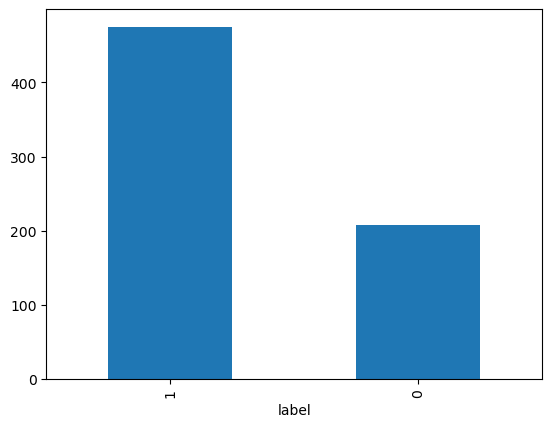

In [12]:
data2['label'].value_counts().plot(kind='bar')

Sample distribution of features

array([[<Axes: title={'center': 'unit_1273_bin_3'}>,
        <Axes: title={'center': 'unit_0901_bin_1'}>,
        <Axes: title={'center': 'unit_1733_bin_2'}>],
       [<Axes: title={'center': 'unit_0231_bin_3'}>,
        <Axes: title={'center': 'unit_1351_bin_3'}>,
        <Axes: title={'center': 'unit_0941_bin_3'}>],
       [<Axes: title={'center': 'unit_1655_bin_2'}>,
        <Axes: title={'center': 'unit_2068_bin_4'}>,
        <Axes: title={'center': 'unit_0637_bin_0'}>],
       [<Axes: title={'center': 'unit_0023_bin_1'}>,
        <Axes: title={'center': 'unit_1884_bin_3'}>,
        <Axes: title={'center': 'unit_0225_bin_0'}>]], dtype=object)

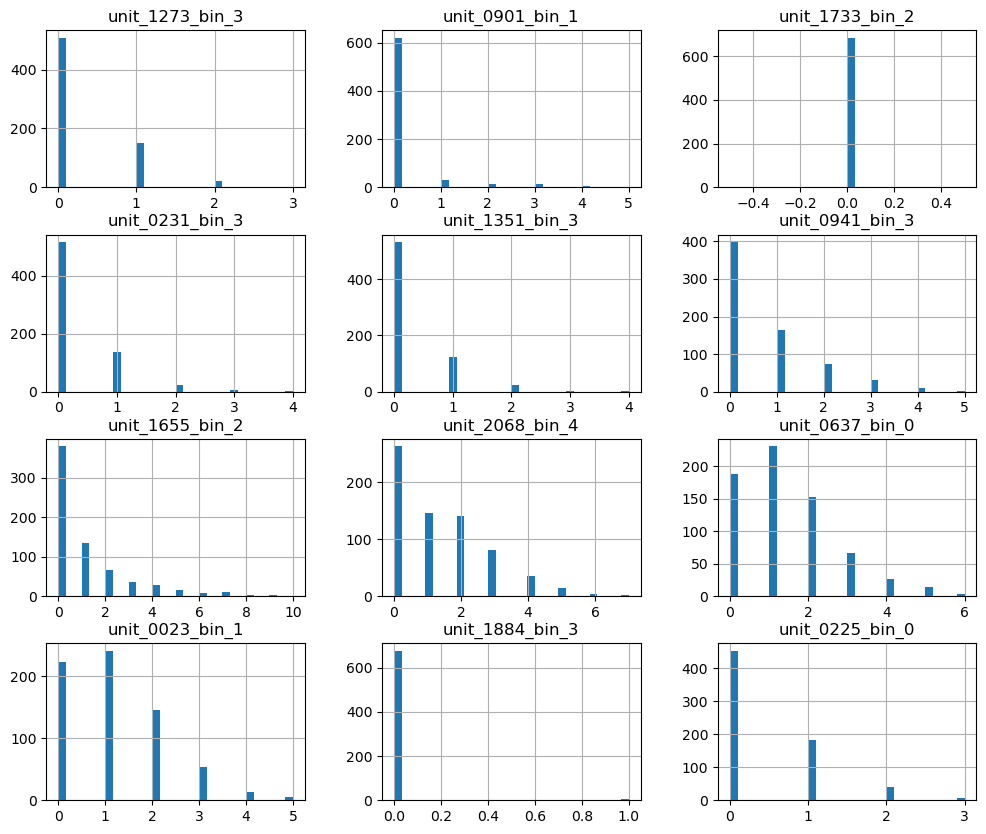

In [13]:
sample_cols = input2.sample(12, axis=1)
sample_cols.hist(bins=30, figsize=(12,10))
# We can see many zeros and typically right-skewed distributions, implying that many features are uninformative
# Linear models (e.g., Logistic Regression) may struggle without regularisation, LASSO/Ridge are appropriate.
# Tree-based models may identify informative subsets automatically

Percentage of zeros (a more intuitive understanding of how prevailing the zeros are from above histo)

In [14]:
zero_prop = (input2 == 0).mean().mean()
print("Zero proportion:", zero_prop)

Zero proportion: 0.7403449272973018


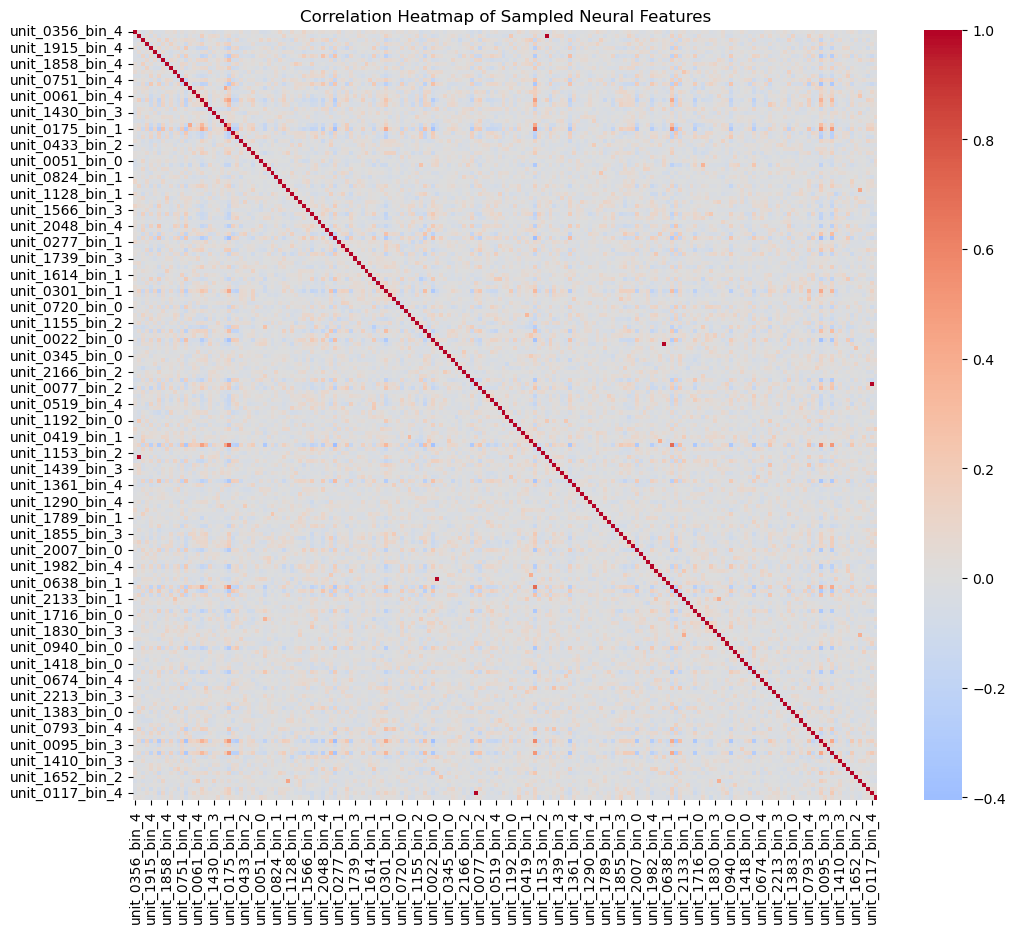

In [15]:
# Just routinely heatmap (select a subset of features for visibility)
# Sample a subset of features (e.g., 200)
subset = input2.sample(200, axis=1)

# Remove constant columns (std = 0)
subset = subset.loc[:, subset.std(axis=0) > 0]

# Compute correlation
corr = subset.corr()

# Replace NaNs if any remain
corr = corr.replace([np.inf, -np.inf], np.nan).fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Sampled Neural Features")
plt.show()
# VERY VERY low correlations between features, only a few pairs show moderate correlation (sparse colour blocks))

For now, we have strong evidence that a large amount of the features are redundant. Hence, we can consider, with confident, LASSO, tree models, and some other methods that helps with high-dimensionality (p>n) and feature selection

### For now, my proposal: 

### course material: 

Lasso Logistic

RF

GBDT

### extracirricular:

Naive Bayes Classifier

XGBoost

Small Multilayer Perceptron (MLP) (1 layer nueral network)